In [1]:
import argparse
import numpy as np
import os
from math import log10, floor
from datetime import datetime
from glob import glob
import stat
import pickle
import math
import array
import scipy
from multiprocessing import Pool
from itertools import repeat
from pathlib import Path
from scipy.signal import correlate
from scipy.fft import ifft, fft, next_fast_len
import qetpy as qp
import matplotlib
import matplotlib.pyplot as plt
import pytesdaq.io.hdf5 as h5io
import yaml
import pytesdaq
from detprocess.core import OptimumFilterTrigger, EventBuilder, Template, Noise, Salting
from detprocess import utils,FilterData
from pprint import pprint
from scipy import stats, signal, interpolate, special, integrate
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import types
import mendeleev
import pickle as pkl
import sys
from darklim import constants

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
#yaml_dict = yaml.load(open('/home/michael/salting/detprocess/examples/processing/process_example.yaml', 'r'), Loader=utils._UniqueKeyLoader)
#salting_dict = yaml_dict['salting']
filter_file = "/home/michael/salting/detprocess/examples/r46testfilterfile.hdf5"
didv_file = "/home/michael/salting/run46tests/pylelab_run46_analysis/didvBOTHCHAN.hdf5"

In [3]:

pdf_file = "/home/michael/salting/detprocess/examples/mass_dict.pkl"


In [4]:
salting = Salting(filter_file, didv_file,verbose=True)

INFO: Loading filter data from file /home/michael/salting/detprocess/examples/r46testfilterfile.hdf5
INFO: Loading filter data from file /home/michael/salting/run46tests/pylelab_run46_analysis/didvBOTHCHAN.hdf5


In [5]:
series = None
restricted=False
salting.set_raw_data_path(group_path="/data/ucb/pylelab/run46/raw/continuous_I2_D20240620_T165135",
                            series=series,
                            restricted=restricted)

In [6]:
template = Template()
template.load_hdf5('./r46testfilterfile.hdf5')
template.describe()

INFO: Loading filter data from file ./r46testfilterfile.hdf5
List of channels: ['Mv3025pcRegular|Mv3025pcBigFins', 'Mv3025pcRegular', 'Mv3025pcBigFins']

Channel Mv3025pcRegular|Mv3025pcBigFins:
 * Tag "default":
    csd: 3D numpy.array  (2, 2, 25000)
 * Tag "freqs_default":
    csd: pandas.Series (25000,)
 * Tag "shared_2x2":
    template: 3D numpy.array  (2, 2, 25000)
 * Tag "shared_Mv3025pcBigFins":
    template: 3D numpy.array  (2, 1, 25000)
 * Tag "shared_Mv3025pcRegular":
    template: 3D numpy.array  (2, 1, 25000)
 * Tag "single_Mv3025pcBigFins":
    template: 3D numpy.array  (2, 1, 25000)
 * Tag "single_Mv3025pcRegular":
    template: 3D numpy.array  (2, 1, 25000)

Channel Mv3025pcRegular:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)
 * Tag "singles":
    template: pandas.Series (25000,)

Channel Mv3025pcBigFins:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)
 * Tag "singles":
    template: pandas

In [7]:
chan = "Mv3025pcRegular|Mv3025pcBigFins"
template_tag = "shared_Mv3025pcRegular"
noise_tag = "default"
pce = [0.4, 0.3]
dpdi_tag = "default"
dpdi_poles = 3

In [8]:
energies=[0.01,0.1,1,10,100,1000]
#if 'energies' in chan_config:
#    energies = chan_config['energies']


In [9]:
salts,filtsalts = salting.generate_salt(chan,
                        noise_tag=noise_tag,
                        template_tag=template_tag,
                        dpdi_tag=dpdi_tag,
                        dpdi_poles=dpdi_poles,
                        energies=energies,
                        PCE = pce,
                        pdf_file=None,
                        nevents=20)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO: Changing number cores to 1 (maximum possible)
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!


In [10]:
salts[1][1]

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.82351143e-17, 7.81678875e-17, 7.81007186e-17])]

In [11]:
temp ,time = salting.get_template("Mv3025pcRegular|Mv3025pcBigFins","shared_Mv3025pcRegular")

In [12]:
print(len(temp))

2


In [13]:
time

array([0.00000e+00, 8.00000e-07, 1.60000e-06, ..., 1.99976e-02,
       1.99984e-02, 1.99992e-02])

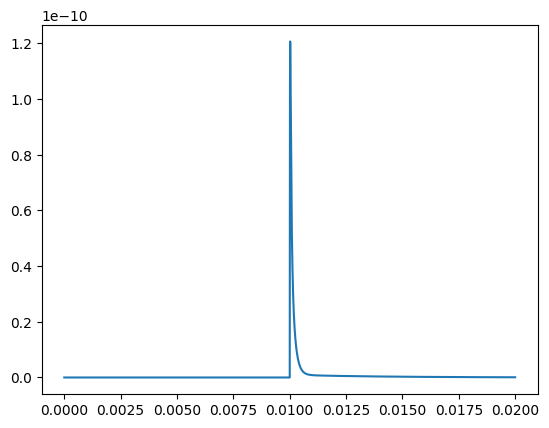

In [14]:
plt.plot(time,salts[0][0][0])

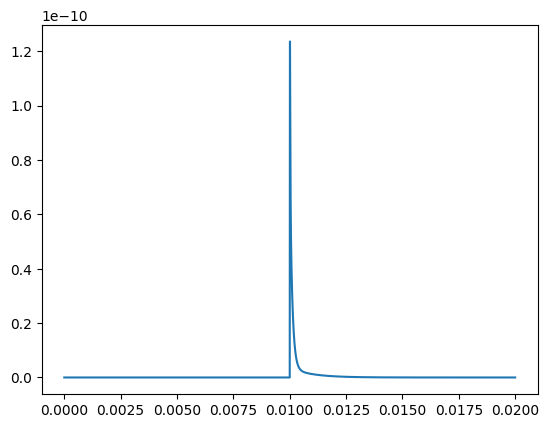

In [15]:
plt.plot(time,salts[0][1][0])

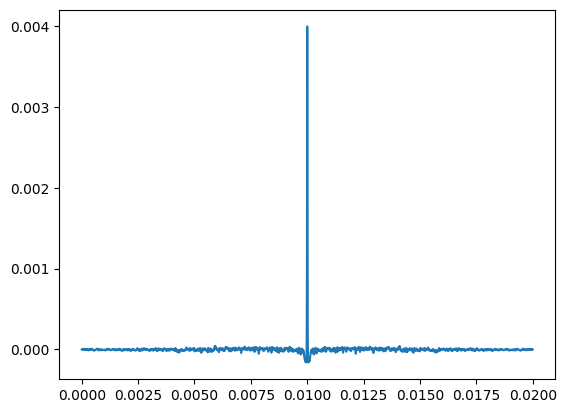

In [16]:
plt.plot(time,filtsalts[0][0][0])

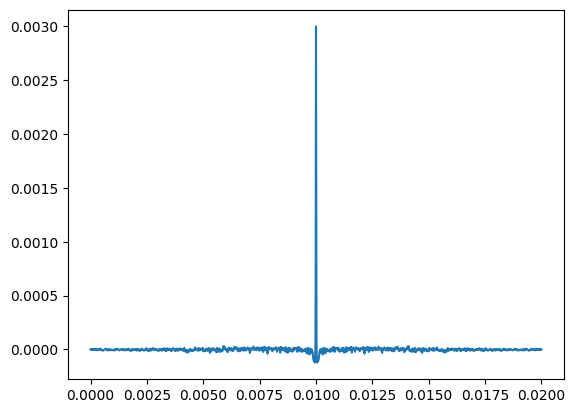

In [17]:
plt.plot(time,filtsalts[0][1][0])

In [18]:
ahh = salting.get_DMenergies()

In [19]:
salting_dataframe = salting.get_dataframe()

In [20]:
salting_dataframe

#,series_number,event_number,dump_number,event_time,series_start_time,group_start_time,fridge_run_start_time,fridge_run_number,trigger_index,trigger_time,trigger_type,data_type,group_name,processing_id,trigger_prod_id,trigger_prod_group_name,salt_template_tag,salt_recoil_energy_eV,saltchanname,salt_amplitude_Mv3025pcRegular,salt_amplitude_Mv3025pcBigFins,salt_filt_amplitude_Mv3025pcRegular,salt_filt_amplitude_Mv3025pcBigFins,salt_energy_eV_Mv3025pcRegular,salt_energy_eV_Mv3025pcBigFins
0,220240620165258,100001,1,1718927591,13,95,291191,46,790971,0.6327768,3,Test,continuous_I2_D20240620_T165135,nan,1,nan,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
1,220240620165258,100001,1,1718927599,21,103,291199,46,11545071,9.2360568,3,Test,continuous_I2_D20240620_T165135,nan,2,nan,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
2,220240620165258,100001,1,1718927600,22,104,291200,46,12244611,9.7956888,3,Test,continuous_I2_D20240620_T165135,nan,3,nan,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
3,220240620165258,100001,1,1718927600,22,104,291200,46,12428900,9.94312,3,Test,continuous_I2_D20240620_T165135,nan,4,nan,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
4,220240620165258,100002,1,1718927601,23,105,291201,46,1089280,0.871424,3,Test,continuous_I2_D20240620_T165135,nan,5,nan,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,220240620165258,300007,3,1718927879,301,383,291479,46,11713937,9.3711496,3,Test,continuous_I2_D20240620_T165135,nan,116,nan,shared_Mv3025pcRegular,1000.0,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-05,1.2353979397437816e-05,400.0,300.0,1000.0,1000.0
116,220240620165258,300008,3,1718927882,304,386,291482,46,2849786,2.2798288,3,Test,continuous_I2_D20240620_T165135,nan,117,nan,shared_Mv3025pcRegular,1000.0,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-05,1.2353979397437816e-05,400.0,300.0,1000.0,1000.0
117,220240620165258,300008,3,1718927886,308,390,291486,46,7247922,5.7983376,3,Test,continuous_I2_D20240620_T165135,nan,118,nan,shared_Mv3025pcRegular,1000.0,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-05,1.2353979397437816e-05,400.0,300.0,1000.0,1000.0
118,220240620165258,300008,3,1718927887,309,391,291487,46,8834428,7.0675424,3,Test,continuous_I2_D20240620_T165135,nan,119,nan,shared_Mv3025pcRegular,1000.0,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-05,1.2353979397437816e-05,400.0,300.0,1000.0,1000.0


In [21]:
for dm_mass in salting_dataframe['salt_dm_mass_MeV'].unique():
    # Filter the data for the current dark matter mass
    filtered_data = salting_dataframe[salting_dataframe['salt_dm_mass_MeV'] == dm_mass]
    
    # Plot histogram for 'salt_recoil_energy_eV' for the current dark matter mass
    plt.hist(filtered_data['salt_recoil_energy_eV'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
    
# Add legend and labels
plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Recoil Energy by Dark Matter Mass')
plt.legend(title='DM Mass (MeV)')
plt.show()

NameError: Column or variable 'salt_dm_mass_MeV' does not exist.

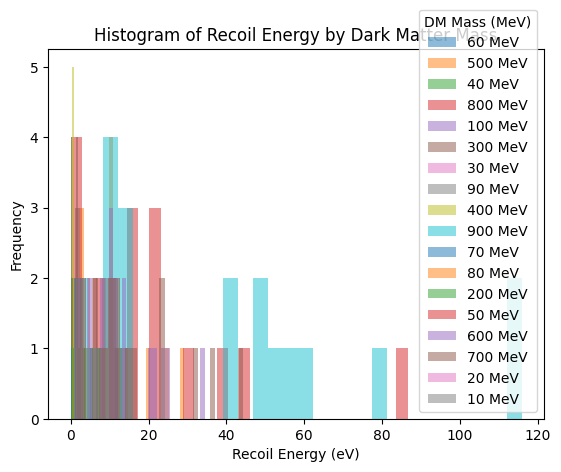

In [21]:
for dm_mass in salting_dataframe['salt_dm_mass_MeV'].unique():
    # Filter the data for the current dark matter mass
    filtered_data = salting_dataframe[salting_dataframe['salt_dm_mass_MeV'] == dm_mass]
    
    # Plot histogram for 'salt_recoil_energy_eV' for the current dark matter mass
    plt.hist(filtered_data['salt_energy_eV_Mv3025pcRegular'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
    
# Add legend and labels
plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Recoil Energy by Dark Matter Mass')
plt.legend(title='DM Mass (MeV)')
plt.show()

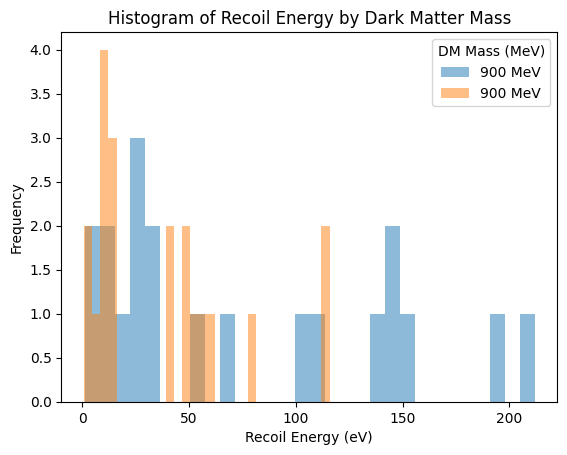

In [22]:
dm_mass = 900
filtered_data = salting_dataframe[salting_dataframe['salt_dm_mass_MeV'] == dm_mass]
plt.hist(filtered_data['salt_recoil_energy_eV'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
plt.hist(filtered_data['salt_energy_eV_Mv3025pcRegular'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Recoil Energy by Dark Matter Mass')
plt.legend(title='DM Mass (MeV)')
plt.show()

In [22]:
salts,filtsalts = salting.generate_salt(chan,
                        noise_tag=noise_tag,
                        template_tag=template_tag,
                        dpdi_tag=dpdi_tag,
                        dpdi_poles=dpdi_poles,
                        energies=energies,
                        PCE = pce,
                        pdf_file=None,
                        nevents=20)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO: Changing number cores to 1 (maximum possible)
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!


In [23]:
chan = "Mv3025pcBigFins"
template_tag = 'default'
noise_tag = "default"
pce = [0.4]
dpdi_tag = "default"
dpdi_poles = 3

In [24]:
#salting.load_hdf5('./r46testfilterfile.hdf5')
#salting.load_hdf5(didv_file)

In [25]:
salts,filtsalts = salting.generate_salt(chan,
                        noise_tag=noise_tag,
                        template_tag=template_tag,
                        dpdi_tag=dpdi_tag,
                        dpdi_poles=dpdi_poles,
                        energies=energies,
                        PCE = pce,
                        pdf_file=None,
                        nevents=100)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO: Changing number cores to 1 (maximum possible)
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!


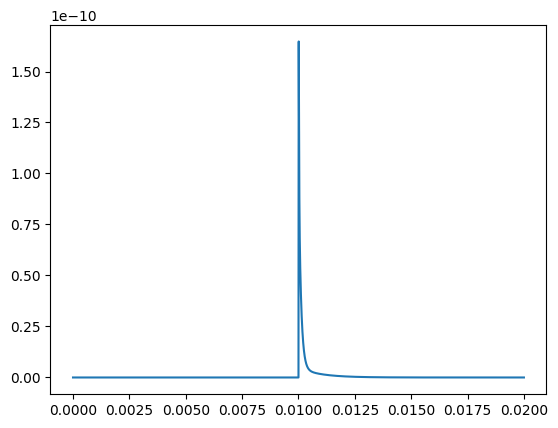

In [26]:
plt.plot(time,salts[0])

In [27]:
salting_dataframe = salting.get_dataframe()

In [28]:
salting_dataframe

#,series_number,event_number,dump_number,event_time,series_start_time,group_start_time,fridge_run_start_time,fridge_run_number,trigger_index,trigger_time,trigger_type,data_type,group_name,processing_id,trigger_prod_id,trigger_prod_group_name,salt_template_tag,salt_recoil_energy_eV,saltchanname,salt_amplitude_Mv3025pcRegular,salt_amplitude_Mv3025pcBigFins,salt_filt_amplitude_Mv3025pcRegular,salt_filt_amplitude_Mv3025pcBigFins,salt_energy_eV_Mv3025pcRegular,salt_energy_eV_Mv3025pcBigFins
0,220240620165258,100001,1,1718927591,13,95,291191,46,790971,0.6327768,3,Test,continuous_I2_D20240620_T165135,0.0,1,0.0,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
1,220240620165258,100001,1,1718927599,21,103,291199,46,11545071,9.2360568,3,Test,continuous_I2_D20240620_T165135,0.0,2,0.0,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
2,220240620165258,100001,1,1718927600,22,104,291200,46,12244611,9.7956888,3,Test,continuous_I2_D20240620_T165135,0.0,3,0.0,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
3,220240620165258,100001,1,1718927600,22,104,291200,46,12428900,9.94312,3,Test,continuous_I2_D20240620_T165135,0.0,4,0.0,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
4,220240620165258,100002,1,1718927601,23,105,291201,46,1089280,0.871424,3,Test,continuous_I2_D20240620_T165135,0.0,5,0.0,shared_Mv3025pcRegular,0.01,Mv3025pcRegular|Mv3025pcBigFins,1.2063504597523714e-10,1.2353979397437818e-10,0.004,0.003,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,220240620165258,300008,3,1718927887,309,391,291487,46,8412198,6.7297584,3,Test,continuous_I2_D20240620_T165135,0.0,566,0.0,default,1000.0,Mv3025pcBigFins,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0
806,220240620165258,300008,3,1718927887,309,391,291487,46,8442876,6.7543008,3,Test,continuous_I2_D20240620_T165135,0.0,567,0.0,default,1000.0,Mv3025pcBigFins,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0
807,220240620165258,300008,3,1718927888,310,392,291488,46,10282686,8.2261488,3,Test,continuous_I2_D20240620_T165135,0.0,568,0.0,default,1000.0,Mv3025pcBigFins,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0
808,220240620165258,300008,3,1718927890,312,394,291490,46,11977449,9.5819592,3,Test,continuous_I2_D20240620_T165135,0.0,569,0.0,default,1000.0,Mv3025pcBigFins,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0


In [29]:
eventID = 100001
seriesID = 220240620165258
filtered_df = salting_dataframe[(salting_dataframe['event_number'] == eventID) & (salting_dataframe['series_number'] == seriesID)]

In [30]:
print(filtered_df.head(10))

  #    series_number    event_number    dump_number    event_time    series_start_time    group_start_time    fridge_run_start_time    fridge_run_number    trigger_index    trigger_time    trigger_type  data_type    group_name                         processing_id    trigger_prod_id    trigger_prod_group_name  salt_template_tag         salt_recoil_energy_eV  saltchanname                       salt_amplitude_Mv3025pcRegular    salt_amplitude_Mv3025pcBigFins    salt_filt_amplitude_Mv3025pcRegular    salt_filt_amplitude_Mv3025pcBigFins    salt_energy_eV_Mv3025pcRegular    salt_energy_eV_Mv3025pcBigFins
  0  220240620165258          100001              1    1718927591                   13                  95                   291191                   46           790971        0.632777               3  Test         continuous_I2_D20240620_T165135                0                  1                          0  shared_Mv3025pcRegular                     0.01  Mv3025pcRegular|Mv3025pcBigFins 

In [31]:
unique_values = filtered_df['salt_amplitude_Mv3025pcBigFins'].unique()  # Converting to list if needed
print("Unique values:", unique_values)

Unique values: [1.647197252991709e-10, 1.2353979397437818e-10]


In [32]:
seriesnum = 220240620165258
eventnum = 100001
chans = ['Mv3025pcRegular','Mv3025pcBigFins']

In [33]:
channels=['Mv3025pcRegular','Mv3025pcBigFins']
continuous_data = '/data/ucb/pylelab/run46/raw/continuous_I2_D20240620_T165135'
continuous_data_series = 'None'
h5 = h5io.H5Reader()
h5.set_files(continuous_data, series=None)
mtraces, mtraces_info = h5.read_many_events(nevents=1, detector_chans=channels, include_metadata=True, adctoamp=True)

In [34]:
newtrace = salting.inject_raw_salt(channels,mtraces,seriesnum,eventnum)

In [35]:
newtrace

[[-3.034317493438721e-07,
  -3.136825323104858e-07,
  -3.2118310928344726e-07,
  -3.34684157371521e-07,
  -3.1468262672424314e-07,
  -3.0218164920806885e-07,
  -2.989314079284668e-07,
  -2.9543113708496094e-07,
  -3.16682767868042e-07,
  -3.34684157371521e-07,
  -3.151826620101929e-07,
  -3.0068154335021975e-07,
  -2.819300889968872e-07,
  -2.9018073081970213e-07,
  -3.099322557449341e-07,
  -3.1443259716033935e-07,
  -3.0418181419372557e-07,
  -2.9643120765686034e-07,
  -2.87180495262146e-07,
  -2.8218011856079103e-07,
  -3.109323263168335e-07,
  -3.249334096908569e-07,
  -3.191829681396484e-07,
  -3.064319849014282e-07,
  -2.93681001663208e-07,
  -2.9493110179901124e-07,
  -3.094322204589844e-07,
  -3.3943452835083007e-07,
  -3.381844282150269e-07,
  -3.2818365097045896e-07,
  -3.104322910308838e-07,
  -2.976813077926636e-07,
  -3.0068154335021975e-07,
  -3.0268168449401855e-07,
  -3.1743283271789553e-07,
  -3.2043306827545165e-07,
  -2.9143083095550537e-07,
  -2.9018073081970213e-07

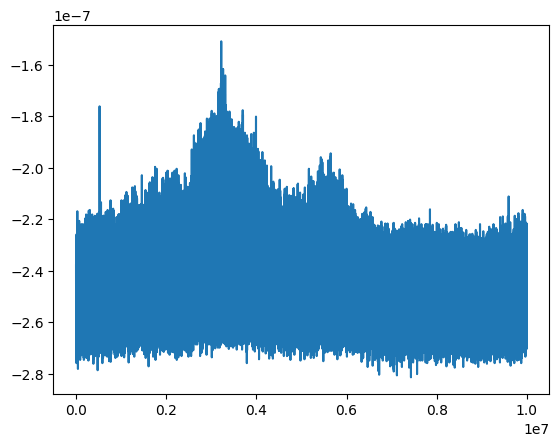

In [36]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,mtraces[0][1])
#plt.xlim(5e5,5.5e5)
#plt.xlim(9e3,1.1e4)
#plt.ylim(-0.2,0.2)
#plt.xlim(9000,11000)

In [44]:
newtrace[0]

[-3.034317493438721e-07,
 -3.136825323104858e-07,
 -3.2118310928344726e-07,
 -3.34684157371521e-07,
 -3.1468262672424314e-07,
 -3.0218164920806885e-07,
 -2.989314079284668e-07,
 -2.9543113708496094e-07,
 -3.16682767868042e-07,
 -3.34684157371521e-07,
 -3.151826620101929e-07,
 -3.0068154335021975e-07,
 -2.819300889968872e-07,
 -2.9018073081970213e-07,
 -3.099322557449341e-07,
 -3.1443259716033935e-07,
 -3.0418181419372557e-07,
 -2.9643120765686034e-07,
 -2.87180495262146e-07,
 -2.8218011856079103e-07,
 -3.109323263168335e-07,
 -3.249334096908569e-07,
 -3.191829681396484e-07,
 -3.064319849014282e-07,
 -2.93681001663208e-07,
 -2.9493110179901124e-07,
 -3.094322204589844e-07,
 -3.3943452835083007e-07,
 -3.381844282150269e-07,
 -3.2818365097045896e-07,
 -3.104322910308838e-07,
 -2.976813077926636e-07,
 -3.0068154335021975e-07,
 -3.0268168449401855e-07,
 -3.1743283271789553e-07,
 -3.2043306827545165e-07,
 -2.9143083095550537e-07,
 -2.9018073081970213e-07,
 -2.961812019348145e-07,
 -2.8443028

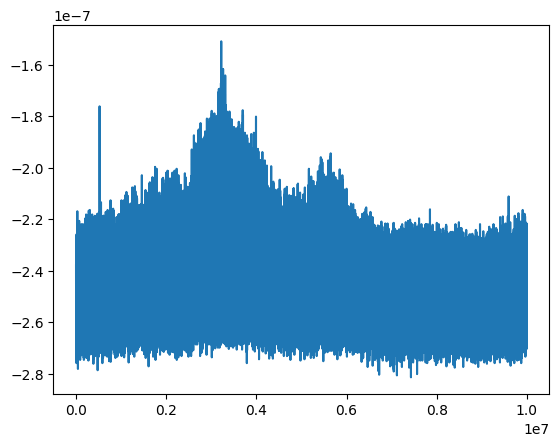

In [38]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,newtrace[1])
#plt.xlim(5e5,5.5e5)
#plt.xlim(9e3,1.1e4)
#plt.ylim(-0.2,0.2)
#plt.xlim(9000,11000)

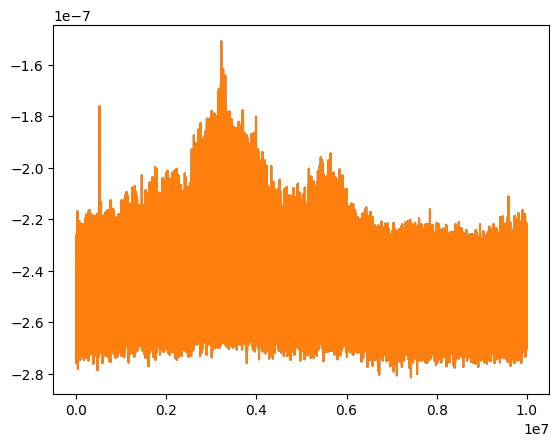

In [39]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,newtrace[1])
plt.plot(bins,mtraces[0][1])
#plt.xlim(5e5,5.5e5)
#plt.xlim(9e3,1.1e4)
#plt.ylim(-0.2,0.2)
#plt.xlim(9000,11000)

In [40]:
justpulses = newtrace[1] - mtraces[0][1]

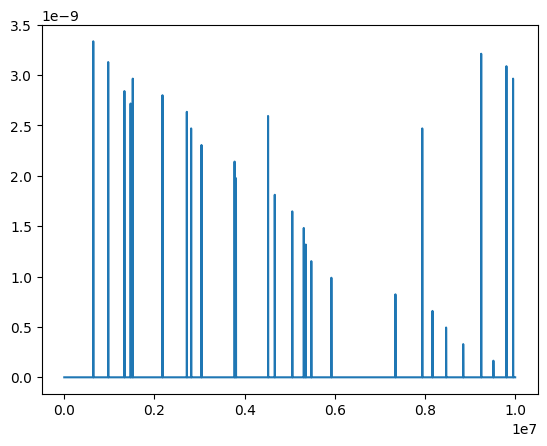

In [41]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,justpulses)

(200000.0, 220000.0)

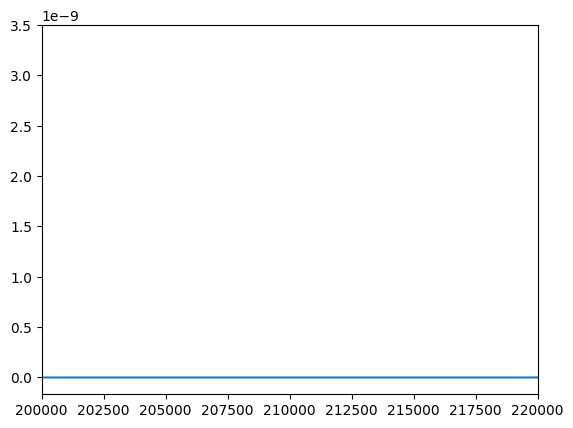

In [42]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,justpulses)
plt.xlim(2e5,2.2e5)